# Project 1 – Classification, weight sharing, auxiliary losses

The objective of this project is to test **different architectures** to compare two digits visible in a
two-channel image. It aims at showing in particular the impact of **weight sharing**, and of the use of an
auxiliary loss to help the training of the main objective.
It should be implemented with PyTorch only code, in particular without using other external libraries
such as scikit-learn or numpy.
## Data
The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate˙pair˙sets(N) defined in the file
dlc˙practical˙prologue.py. 

This function returns six tensors:

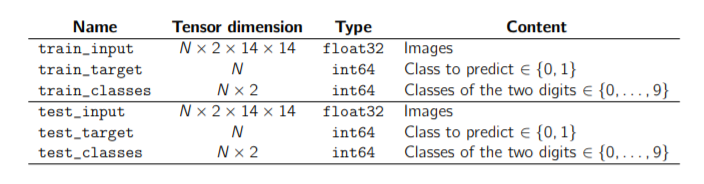

## Objective
The goal of the project is to compare different architectures, and assess the performance improvement that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can in particular take advantage of the availability of the classes of the two digits in each pair, beside the Boolean value truly of interest. All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000 parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error rate. Performance estimates provided in your report should be estimated through 10+ rounds for each architecture, where both data and weight initialization are randomized, and you should provide estimates of standard deviations

Need to add normalization of the train data. 

### Load the data

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
N = 1000

%matplotlib inline

In [2]:
train_inputs, train_targets, train_classes, test_inputs, test_targets, test_classes = prologue.generate_pair_sets(N)

# Normalize the training sets
mu, std = train_inputs.mean(), train_inputs.std() 
train_inputs.sub_(mu).div_(std)

# Normalize the test sets
test_inputs.sub_(mu).div_(std)

train_targets, test_targets = train_targets.float(), test_targets.float()

### Get a sense of it

Let us print the sizes of the tensors:

In [3]:
for name, tensor in zip(['train_input', 'train_target', 'train_classes', 'test_input', 'test_target', 'test_classes'], 
                        [train_inputs, train_targets, train_classes, test_inputs, test_targets, test_classes]):
    print(name, tensor.size())

train_input torch.Size([1000, 2, 14, 14])
train_target torch.Size([1000])
train_classes torch.Size([1000, 2])
test_input torch.Size([1000, 2, 14, 14])
test_target torch.Size([1000])
test_classes torch.Size([1000, 2])


Everything looks fine!

Now let us make sure that the `train_target` really corresponds to the `train_classes`.

In [4]:
# For example, for the first one
print('train_classes are', train_classes[0])
print('train_target is', train_targets[0])

# For example, for the fourth one
print('train_classes are', train_classes[4])
print('train_target is', train_targets[4])

# For example, for the sixth one
print('train_classes are', train_classes[6])
print('train_target is', train_targets[6])

train_classes are tensor([9, 3])
train_target is tensor(0.)
train_classes are tensor([8, 8])
train_target is tensor(1.)
train_classes are tensor([8, 9])
train_target is tensor(1.)


Funny, but everything looks fine!

In [5]:
def train_model(model, train_inputs, train_targets, mini_batch_size=100, test_inputs=None,
                test_targets=None, remember_train_losses=True, remember_test_losses=True, 
                lr=1e-3, nb_epochs=20):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train_inputs : torch.Tensor object
            The input train feature set
        train_targets : torch.Tensor object
            The input train label set
        mini_batch_size : int
            The size of the batch processing size
        train_inputs : torch.Tensor object
            The input test feature set
        train_targets : torch.Tensor object
            The input test label set
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list) or (NN object, list, list)
            If either remember_train_losses or remember_test_losses
            is True then the function returns both the trained model 
            and the list of train/test losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
            If both remember_train_losses or remember_test_losses
            are True then the function returns the trained model 
            and lists of train and test losses for each epoch.
    """
    
    if remember_train_losses:
        train_losses = []
    
    if remember_test_losses:
        test_losses = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target in zip(train_inputs.split(mini_batch_size), train_targets.split(mini_batch_size)):
            output = model(train_input)
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        
        if remember_train_losses:
            train_losses.append(loss)
        
        if remember_test_losses:
            test_outputs = model(test_inputs)
            test_losses.append(criterion(test_outputs, test_targets))
            
        print('%dth epoch is finished and the train loss is %f' % (e + 1, loss))
           
    return model, train_losses, test_losses

def compute_nb_errors(model, data_inputs, targets, mini_batch_size=100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        tensor_inputs : torch.Tensor object
            The input feature set
        targets : torch.Tensor object
            The input label set
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    
    # Processing the data set by mini batches
    for data_input, target in zip(data_inputs.split(mini_batch_size), targets.split(mini_batch_size)):
        output = model(data_input)
        nb_errors += (((output > 0) & (target == 0)) | ((output <= 0) & (target == 1))).sum().item()
                
    return nb_errors

# Architectures

## Convnet with two signals corresponding to each image.

In [6]:
class TwoChannel(nn.Module):
    def __init__(self, nb_hidden = 128):        
        super(TwoChannel, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        self.fc3 = nn.Linear(10, 1)
        
        ## we can play by 
        ## 1. add more and different layers
        ## 2. change number of hidden unit. Actually I think here is too much for the input dimension
        ## 3. kernel size but this should fit

    def forward(self, x):
        
        # input has [mini_batch_size, 2, 14, 14], output has [mini_batch_size, 32, 5, 5]
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        
        # input has [mini_batch_size, 32, 5, 5], output has [mini_batch_size, 64, 2, 2]
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2)) 
        
        # input has [mini_batch_size, 64, 2, 2], output has [mini_batch_size, 256]
        x = x.view(x.size(0), -1) ## (at least in my mind) this view should keep track of the two images

        # input has [mini_batch_size, 256], output has [mini_batch_size, nb_hidden]
        x = F.relu(self.fc1(x))
        
        # input has [mini_barch_size, 128], output has [mini_batch_size, 10]
        x = F.relu(self.fc2(x))
        
        # input has [mini_barch_size, 10], output is 1D mini_batch_size vector
        x = self.fc3(x).view(-1)
        
        return x

In [7]:
two_channel_net = TwoChannel()
two_channel_net, train_losses, test_losses = \
    train_model(two_channel_net, train_inputs, train_targets, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.682170
2th epoch is finished and the train loss is 0.648079
3th epoch is finished and the train loss is 0.588719
4th epoch is finished and the train loss is 0.524871
5th epoch is finished and the train loss is 0.449356
6th epoch is finished and the train loss is 0.443090
7th epoch is finished and the train loss is 0.395762
8th epoch is finished and the train loss is 0.368032
9th epoch is finished and the train loss is 0.353144
10th epoch is finished and the train loss is 0.332180
11th epoch is finished and the train loss is 0.324495
12th epoch is finished and the train loss is 0.327467
13th epoch is finished and the train loss is 0.304027
14th epoch is finished and the train loss is 0.275261
15th epoch is finished and the train loss is 0.244430
16th epoch is finished and the train loss is 0.212974
17th epoch is finished and the train loss is 0.186586
18th epoch is finished and the train loss is 0.162868
19th epoch is finished and the train 

In [8]:
nb_errors_train = compute_nb_errors(two_channel_net, train_inputs, train_targets)
nb_errors_test = compute_nb_errors(two_channel_net, test_inputs, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 981 out of 1000
Number of correct test classifications: 802 out of 1000


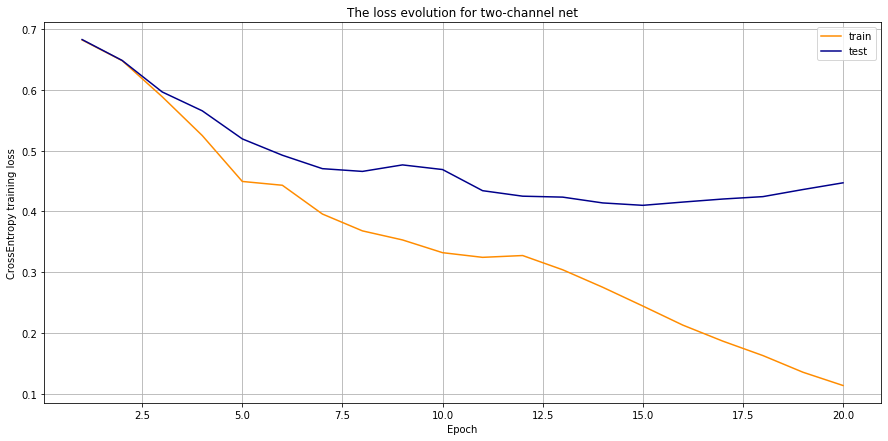

In [9]:
nb_epochs = 20

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net')
ax.legend();

## Convnet with two branches, each processes her own image.

In [10]:
def train_model_two_branch(model, train_inputs, train_targets, mini_batch_size=100, test_inputs=None,
                test_targets=None, remember_train_losses=True, remember_test_losses=True, 
                lr=1e-3, nb_epochs=20):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train_inputs : torch.Tensor object
            The input train feature set
        train_targets : torch.Tensor object
            The input train label set
        mini_batch_size : int
            The size of the batch processing size
        train_inputs : torch.Tensor object
            The input test feature set
        train_targets : torch.Tensor object
            The input test label set
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list) or (NN object, list, list)
            If either remember_train_losses or remember_test_losses
            is True then the function returns both the trained model 
            and the list of train/test losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
            If both remember_train_losses or remember_test_losses
            are True then the function returns the trained model 
            and lists of train and test losses for each epoch.
    """
    
    if remember_train_losses:
        train_losses = []
    
    if remember_test_losses:
        test_losses = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target in zip(train_inputs.split(mini_batch_size), train_targets.split(mini_batch_size)):
            output = model(train_input[:, 0].view(mini_batch_size, 1, 14, 14), train_input[:, 1].view(mini_batch_size, 1, 14, 14))
            loss = criterion(output, train_target) 
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        
        if remember_train_losses:
            train_losses.append(loss)
        
        if remember_test_losses:
            test_outputs = model(test_inputs[:, 0].view(-1, 1, 14, 14), test_inputs[:, 1].view(-1, 1, 14, 14))
            test_losses.append(criterion(test_outputs, test_targets))
            
        print('%dth epoch is finished and the train loss is %f' % (e + 1, loss))
           
    return model, train_losses, test_losses

def compute_nb_errors_two_branch(model, data_inputs, targets, mini_batch_size=100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        tensor_inputs : torch.Tensor object
            The input feature set
        targets : torch.Tensor object
            The input label set
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    
    # Processing the data set by mini batches
    for data_input, target in zip(data_inputs.split(mini_batch_size), targets.split(mini_batch_size)):
        output = model(data_input[:, 0].view(mini_batch_size, 1, 14, 14), data_input[:, 1].view(mini_batch_size, 1, 14, 14))
        nb_errors += (((output > 0) & (target == 0)) | ((output <= 0) & (target == 1))).sum().item()
                
    return nb_errors

In [11]:
class TwoBranch(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranch, self).__init__()
        
        # Convolutional layers on the first branch
        self.cnn_first = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the first branch
        self.fc_first = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
            
        )
        
        # Convolutional layers on the second branch
        self.cnn_second = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the second branch
        self.fc_second = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
            
        )
    
    def forward_first(self, x):
        x = self.cnn_first(x)
        x = x.view(x.size(0), -1)
        x = self.fc_first(x)
        return x
    
    def forward_second(self, x):
        x = self.cnn_second(x)
        x = x.view(x.size(0), -1)
        x = self.fc_second(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_first(input1)
        output_2 = self.forward_second(input2)
        output = (output_2 - output_1).view(-1)
        return output

In [12]:
two_branch_net = TwoBranch()
two_branch_net, train_losses, test_losses = \
    train_model_two_branch(two_branch_net, train_inputs, train_targets, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.673120
2th epoch is finished and the train loss is 0.642685
3th epoch is finished and the train loss is 0.575101
4th epoch is finished and the train loss is 0.503688
5th epoch is finished and the train loss is 0.421828
6th epoch is finished and the train loss is 0.364303
7th epoch is finished and the train loss is 0.321276
8th epoch is finished and the train loss is 0.298924
9th epoch is finished and the train loss is 0.274817
10th epoch is finished and the train loss is 0.251823
11th epoch is finished and the train loss is 0.229452
12th epoch is finished and the train loss is 0.212684
13th epoch is finished and the train loss is 0.216725
14th epoch is finished and the train loss is 0.236694
15th epoch is finished and the train loss is 0.155365
16th epoch is finished and the train loss is 0.136276
17th epoch is finished and the train loss is 0.131638
18th epoch is finished and the train loss is 0.112440
19th epoch is finished and the train 

In [13]:
nb_errors_train = compute_nb_errors_two_branch(two_branch_net, train_inputs, train_targets)
nb_errors_test = compute_nb_errors_two_branch(two_branch_net, test_inputs, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 988 out of 1000
Number of correct test classifications: 843 out of 1000


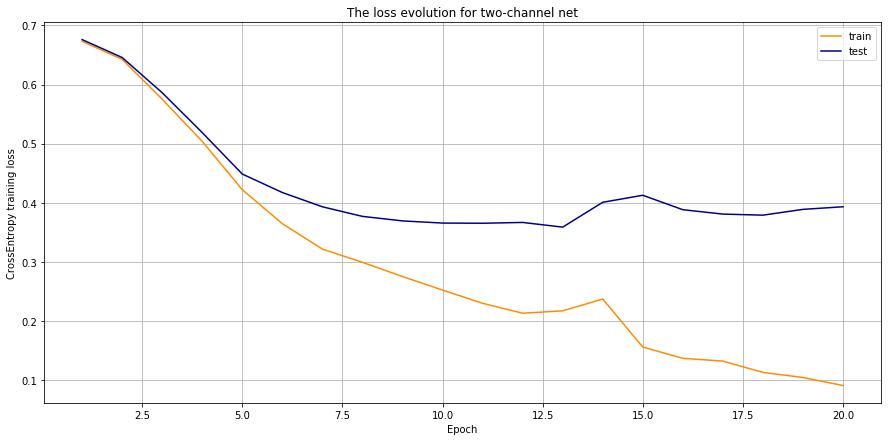

In [14]:
nb_epochs = 20

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net')
ax.legend();

## Convnet with two branches, each processes her own image + weight sharing.

In [15]:
class TwoBranchSameWeight(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSameWeight, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
            
        )
        
    
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_single(input1)
        output_2 = self.forward_single(input2)
        output = (output_2 - output_1).view(-1)
        return output

In [16]:
two_branch_same_weight_net = TwoBranchSameWeight()
two_branch_same_weight_net, train_losses, test_losses = \
    train_model_two_branch(two_branch_same_weight_net, train_inputs, train_targets, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.657930
2th epoch is finished and the train loss is 0.541185
3th epoch is finished and the train loss is 0.392884
4th epoch is finished and the train loss is 0.356253
5th epoch is finished and the train loss is 0.325476
6th epoch is finished and the train loss is 0.307472
7th epoch is finished and the train loss is 0.273617
8th epoch is finished and the train loss is 0.243346
9th epoch is finished and the train loss is 0.221760
10th epoch is finished and the train loss is 0.196523
11th epoch is finished and the train loss is 0.170593
12th epoch is finished and the train loss is 0.148807
13th epoch is finished and the train loss is 0.118277
14th epoch is finished and the train loss is 0.085140
15th epoch is finished and the train loss is 0.062525
16th epoch is finished and the train loss is 0.063687
17th epoch is finished and the train loss is 0.033193
18th epoch is finished and the train loss is 0.009921
19th epoch is finished and the train 

In [17]:
nb_errors_train = compute_nb_errors_two_branch(two_branch_same_weight_net, train_inputs, train_targets)
nb_errors_test = compute_nb_errors_two_branch(two_branch_same_weight_net, test_inputs, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 1000 out of 1000
Number of correct test classifications: 846 out of 1000


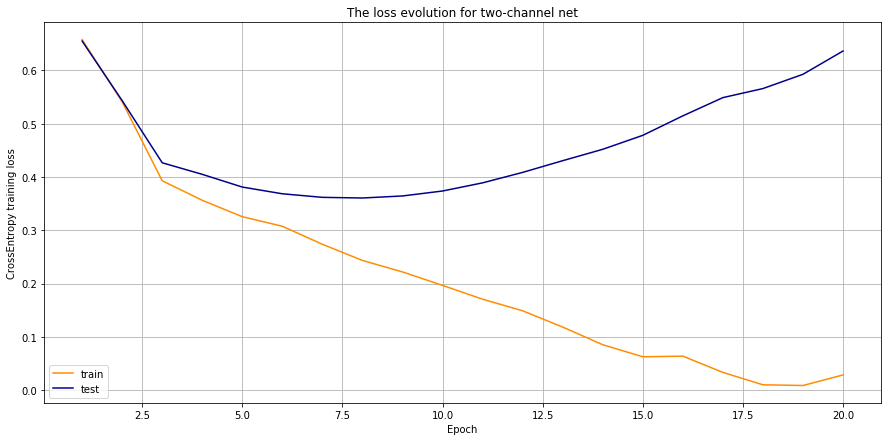

In [18]:
nb_epochs = 20

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net')
ax.legend();

## Convnet with two branches, each processes her own image -> different architecture.

In [19]:
class TwoBranchSecond(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecond, self).__init__()
        
        # Convolutional layers on the first branch
        self.cnn_first = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the first branch
        self.fc_first = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            
        )
        
        # Convolutional layers on the second branch
        self.cnn_second = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers on the second branch
        self.fc_second = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            
        )
        
        self.fc_prefinal = nn.Linear(20, 10)
        self.fc_final = nn.Linear(10, 1)
    
    def forward_first(self, x):
        x = self.cnn_first(x)
        x = x.view(x.size(0), -1)
        x = self.fc_first(x)
        return x
    
    def forward_second(self, x):
        x = self.cnn_second(x)
        x = x.view(x.size(0), -1)
        x = self.fc_second(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_first(input1)
        output_2 = self.forward_second(input2)
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output = self.fc_final(output).view(-1)
        return output

In [20]:
two_branch_second_net = TwoBranchSecond()
two_branch_second_net, train_losses, test_losses = \
    train_model_two_branch(two_branch_second_net, train_inputs, train_targets, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.676703
2th epoch is finished and the train loss is 0.640231
3th epoch is finished and the train loss is 0.563848
4th epoch is finished and the train loss is 0.469769
5th epoch is finished and the train loss is 0.412607
6th epoch is finished and the train loss is 0.376078
7th epoch is finished and the train loss is 0.349396
8th epoch is finished and the train loss is 0.325839
9th epoch is finished and the train loss is 0.301281
10th epoch is finished and the train loss is 0.281221
11th epoch is finished and the train loss is 0.268761
12th epoch is finished and the train loss is 0.269909
13th epoch is finished and the train loss is 0.246561
14th epoch is finished and the train loss is 0.215374
15th epoch is finished and the train loss is 0.195305
16th epoch is finished and the train loss is 0.183469
17th epoch is finished and the train loss is 0.183267
18th epoch is finished and the train loss is 0.175607
19th epoch is finished and the train 

In [21]:
nb_errors_train = compute_nb_errors_two_branch(two_branch_second_net, train_inputs, train_targets)
nb_errors_test = compute_nb_errors_two_branch(two_branch_second_net, test_inputs, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 929 out of 1000
Number of correct test classifications: 817 out of 1000


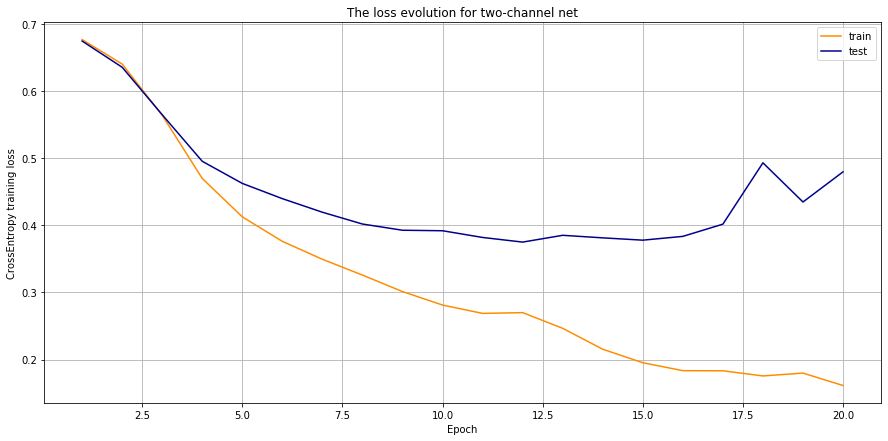

In [22]:
nb_epochs = 20

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net')
ax.legend();

## Convnet with two branches, each processes her own image -> different architecture + weight sharing.

In [23]:
class TwoBranchSecondSameWeight(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecondSameWeight, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            nn.Linear(nb_hidden, 10),
            nn.ReLU(),
            
        )
        
        self.fc_prefinal = nn.Linear(20, 10)
        self.fc_final = nn.Linear(10, 1)
        
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_single(input1)
        output_2 = self.forward_single(input2)
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output = self.fc_final(output).view(-1)
        return output

In [24]:
two_branch_second_same_weight_net = TwoBranchSecondSameWeight()
two_branch_second_same_weight_net, train_losses, test_losses = \
    train_model_two_branch(two_branch_second_same_weight_net, train_inputs, train_targets, test_inputs=test_inputs, test_targets=test_targets)

1th epoch is finished and the train loss is 0.675388
2th epoch is finished and the train loss is 0.616907
3th epoch is finished and the train loss is 0.492140
4th epoch is finished and the train loss is 0.411618
5th epoch is finished and the train loss is 0.376927
6th epoch is finished and the train loss is 0.358166
7th epoch is finished and the train loss is 0.327919
8th epoch is finished and the train loss is 0.297395
9th epoch is finished and the train loss is 0.271466
10th epoch is finished and the train loss is 0.243970
11th epoch is finished and the train loss is 0.210130
12th epoch is finished and the train loss is 0.181312
13th epoch is finished and the train loss is 0.154384
14th epoch is finished and the train loss is 0.129226
15th epoch is finished and the train loss is 0.110792
16th epoch is finished and the train loss is 0.098391
17th epoch is finished and the train loss is 0.084449
18th epoch is finished and the train loss is 0.074957
19th epoch is finished and the train 

In [25]:
nb_errors_train = compute_nb_errors_two_branch(two_branch_second_same_weight_net, train_inputs, train_targets)
nb_errors_test = compute_nb_errors_two_branch(two_branch_second_same_weight_net, test_inputs, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 999 out of 1000
Number of correct test classifications: 856 out of 1000


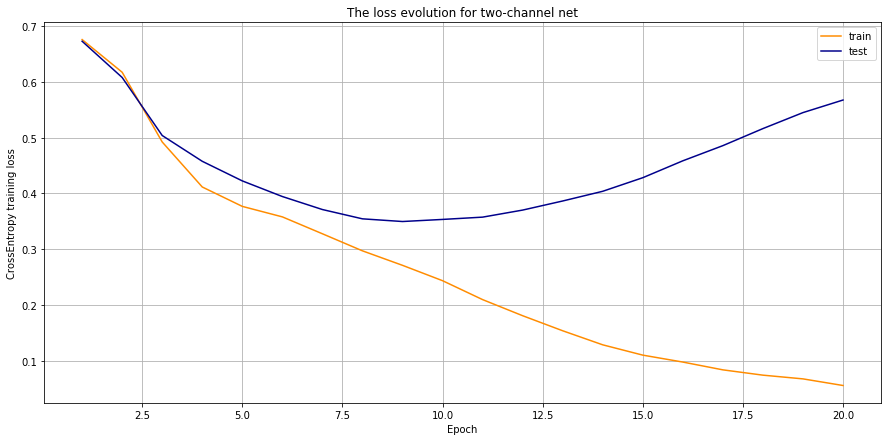

In [26]:
import matplotlib.pyplot as plt
nb_epochs = 20

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net')
ax.legend();

## Convnet with two branches, each processes her own image -> different architecture + weight sharing + auxiliary losses.

In [27]:
def train_model_auxiliary(model, train_inputs, train_targets, train_classes, mini_batch_size=100, test_inputs=None,
                test_targets=None, test_classes=None, remember_train_losses=True, remember_test_losses=True, 
                lr=1e-3, nb_epochs=20):
    
    """
        Train the PyTorch model on the training set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        train_inputs : torch.Tensor object
            The input train feature set
        train_targets : torch.Tensor object
            The input train label set
        mini_batch_size : int
            The size of the batch processing size
        train_inputs : torch.Tensor object
            The input test feature set
        train_targets : torch.Tensor object
            The input test label set
        remember_train_losses : boolean
            True if remember train losses for model evaluation, False if not
        remember_test_losses : boolean
            True if remember test losses for model evaluation, False if not   
        lr : float
            Learning rate for the model training
        nb_epochs : int
            The number of epochs used to train the model
            
        Returns
        -------
        
        NN object or (NN object, list) or (NN object, list, list)
            If either remember_train_losses or remember_test_losses
            is True then the function returns both the trained model 
            and the list of train/test losses for each epoch. 
            If remember_losses is False then the function return only
            the trained model.
            If both remember_train_losses or remember_test_losses
            are True then the function returns the trained model 
            and lists of train and test losses for each epoch.
    """
    
    if remember_train_losses:
        train_losses = []
    
    if remember_test_losses:
        test_losses = []

    # Defining the optimizer for GD
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
    
    # Defining the criterion to calculate loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Defining the criterion for digit recognition
    criterion_digit = nn.CrossEntropyLoss()
    
    # Learning loop
    for e in range(nb_epochs):
        # Train the input dataset by dividing it into mini_batch_size small datasets
        for train_input, train_target, train_class in zip(train_inputs.split(mini_batch_size), 
                                             train_targets.split(mini_batch_size),
                                             train_classes.split(mini_batch_size)):
            output_comparison, output_first_digit, output_second_digit = \
                model(train_input[:, 0].view(mini_batch_size, 1, 14, 14), train_input[:, 1].view(mini_batch_size, 1, 14, 14))
            loss_comparison = criterion(output_comparison, train_target) 
            loss_first = criterion_digit(output_first_digit, train_class[:, 0])
            loss_second = criterion_digit(output_second_digit, train_class[:, 1])
            loss = loss_comparison + loss_first + loss_second
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
        
        if remember_train_losses:
            train_losses.append(loss)
        
        if remember_test_losses:
            test_comparison, test_first_digit, test_second_digit = \
                model(test_inputs[:, 0].view(-1, 1, 14, 14), test_inputs[:, 1].view(-1, 1, 14, 14))
            testloss_comparison = criterion(test_comparison, test_targets) 
            testloss_first = criterion_digit(test_first_digit, test_classes[:, 0])
            testloss_second = criterion_digit(test_second_digit, test_classes[:, 1])
            testloss = testloss_comparison + testloss_first + testloss_second
            test_losses.append(testloss)
            
        print('%dth epoch is finished and the train loss is %f' % (e + 1, loss))
           
    return model, train_losses, test_losses

def compute_nb_errors_auxiliary(model, data_inputs, targets, mini_batch_size=100):
    
    """
        Compute the number of errors the model infers on the data set.
        
        Parameters
        ----------
        model : PyTorch NN object
            PyTorch neural network model      
        tensor_inputs : torch.Tensor object
            The input feature set
        targets : torch.Tensor object
            The input label set
        mini_batch_size : int
            The size of the batch processing size
            
        Returns
        -------
        int
            The number of errors the model infers
    """
    
    nb_errors = 0
    
    # Processing the data set by mini batches
    for data_input, target in zip(data_inputs.split(mini_batch_size), targets.split(mini_batch_size)):
        output, _, _ = model(data_input[:, 0].view(mini_batch_size, 1, 14, 14), data_input[:, 1].view(mini_batch_size, 1, 14, 14))
        nb_errors += (((output > 0) & (target == 0)) | ((output <= 0) & (target == 1))).sum().item()
                
    return nb_errors

In [28]:
class TwoBranchSecondSameWeightAuxiliaryLoss(nn.Module):
    def __init__(self, nb_hidden = 128):
        super(TwoBranchSecondSameWeightAuxiliaryLoss, self).__init__()
        
        # Convolutional layers in each branch
        self.cnn_single = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
            
        )

        # Fully-connected layers in each branch
        self.fc_single = nn.Sequential(
            
            nn.Linear(256, nb_hidden),
            nn.ReLU(),
            
        )
        
        self.fc_prefinal = nn.Linear(2*nb_hidden, 100)
        self.fc_comparison = nn.Linear(100, 1)
        self.fc_first_digit = nn.Linear(100, 10)
        self.fc_second_digit = nn.Linear(100, 10)
        
    def forward_single(self, x):
        x = self.cnn_single(x)
        x = x.view(x.size(0), -1)
        x = self.fc_single(x)
        return x

    def forward(self, input1, input2):
        output_1 = self.forward_single(input1)
        output_2 = self.forward_single(input2)
        output = torch.cat((output_1, output_2), 1)
        output = F.relu(self.fc_prefinal(output))
        output_comparison = self.fc_comparison(output).view(-1)
        output_first_digit = self.fc_first_digit(output)
        output_second_digit = self.fc_second_digit(output)
        return output_comparison, output_first_digit, output_second_digit

In [29]:
two_branch_second_same_weight_auxiliary_net = TwoBranchSecondSameWeightAuxiliaryLoss()
two_branch_second_same_weight_auxiliary_net, train_losses, test_losses = \
    train_model_auxiliary(two_branch_second_same_weight_auxiliary_net, train_inputs, train_targets, train_classes, test_inputs=test_inputs, test_targets=test_targets, test_classes=test_classes)

1th epoch is finished and the train loss is 5.199924
2th epoch is finished and the train loss is 4.884405
3th epoch is finished and the train loss is 4.096507
4th epoch is finished and the train loss is 3.135880
5th epoch is finished and the train loss is 2.411085
6th epoch is finished and the train loss is 2.000958
7th epoch is finished and the train loss is 1.700868
8th epoch is finished and the train loss is 1.457294
9th epoch is finished and the train loss is 1.307955
10th epoch is finished and the train loss is 1.243956
11th epoch is finished and the train loss is 1.058666
12th epoch is finished and the train loss is 0.992321
13th epoch is finished and the train loss is 0.959725
14th epoch is finished and the train loss is 0.859277
15th epoch is finished and the train loss is 0.833140
16th epoch is finished and the train loss is 0.782443
17th epoch is finished and the train loss is 0.649850
18th epoch is finished and the train loss is 0.587694
19th epoch is finished and the train 

In [30]:
nb_errors_train = compute_nb_errors_auxiliary(two_branch_second_same_weight_auxiliary_net, train_inputs, train_targets)
nb_errors_test = compute_nb_errors_auxiliary(two_branch_second_same_weight_auxiliary_net, test_inputs, test_targets)

print('Number of correct train classifications: %d out of %d\nNumber of correct test classifications: %d out of %d' % 
      (train_inputs.size(0) - nb_errors_train, train_inputs.size(0), 
       test_inputs.size(0) - nb_errors_test, test_inputs.size(0)))

Number of correct train classifications: 906 out of 1000
Number of correct test classifications: 872 out of 1000


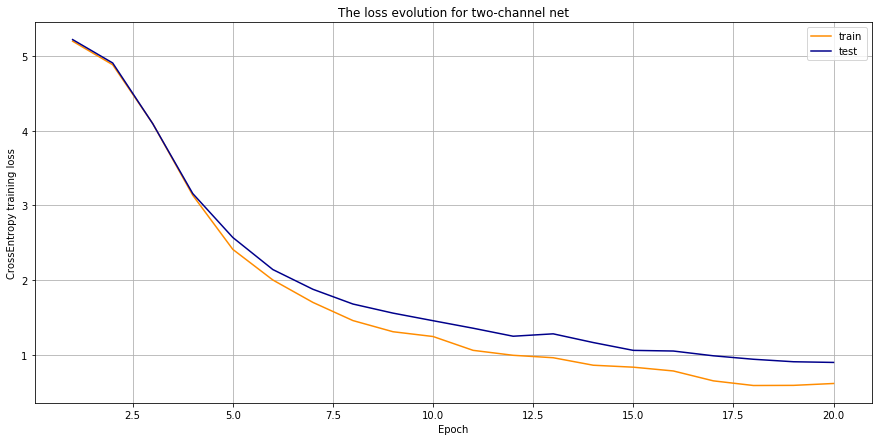

In [31]:
nb_epochs = 20

# Creating an array with nb_epoch values
epochs = range(1, nb_epochs+1)

# Plotting the figure
f, ax = plt.subplots(figsize=(15, 7))

ax.plot(epochs, train_losses, 'darkorange', label='train')
ax.plot(epochs, test_losses, 'darkblue', label='test')
ax.set_ylabel('CrossEntropy training loss')
ax.set_xlabel('Epoch')
ax.grid('True')
ax.set_title('The loss evolution for two-channel net')
ax.legend();

¯\_(ツ)_/¯